## 16 QAM DATASET GENERATION

### Optical Fiber Channel Effects 

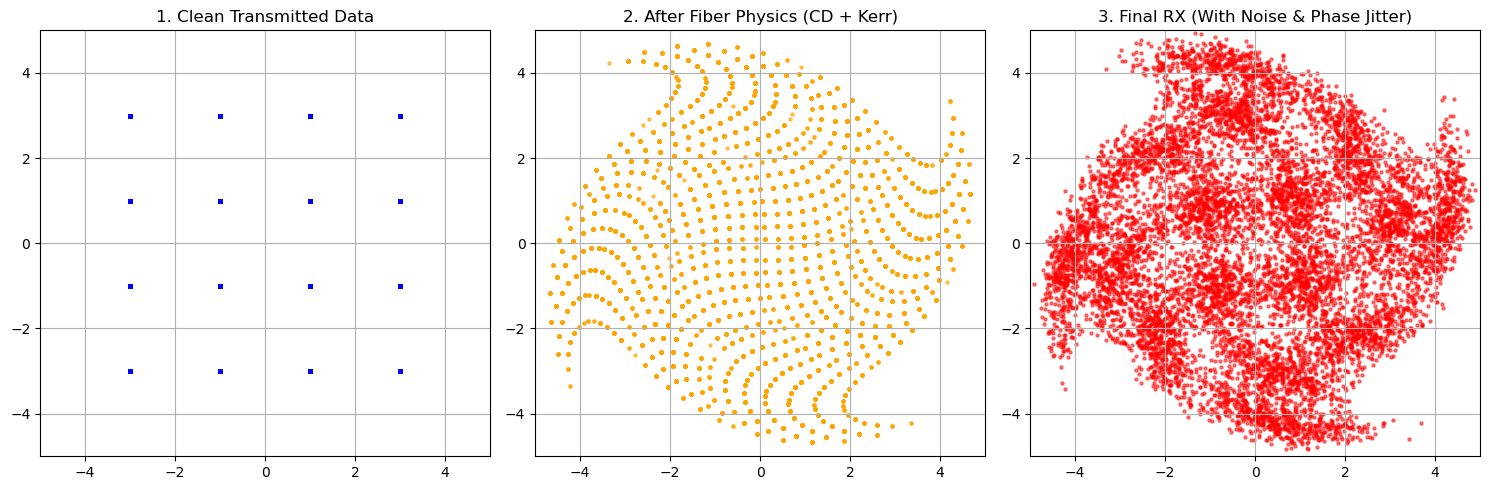

Data Generation Complete. Use 'rx_final' as input to your Neural Network.


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. PARAMETERS (Fixed for Solvability)
# =============================================================================
M = 16              # 16-QAM
num_symbols = 10000 
SNR_dB = 25         # Increased slightly to make the "Twist" visible

# --- Physics Parameters ---
# Chromatic Dispersion (ISI) - KEEP THIS
CD_strength = 0.3   

# Nonlinearity (Kerr Effect) - KEEP THIS (This is what you want to solve!)
gamma = 0.05        

# Phase Noise (Laser Linewidth) - CHANGE THIS
# Old value: 0.02 (Causes "Spinning Wheel" blur)
# New value: 0.0 (Focus on Non-linearity/ISI first) OR 0.0001 for mild jitter
phase_noise_strength = 0.0001

# =============================================================================
# 2. TRANSMITTER (Clean 16-QAM)
# =============================================================================
points = np.array([-3, -1, 1, 3])
constellation = np.array([r + 1j*i for r in points for i in points])
random_indices = np.random.randint(0, M, num_symbols)
tx_symbols = constellation[random_indices]

# =============================================================================
# 3. OPTICAL CHANNEL SIMULATION (The "Complex Equations")
# =============================================================================

# --- Stage A: Chromatic Dispersion (CD) -> Adds Memory/ISI ---
# In fiber, different colors travel at different speeds, blurring pulses.
# We model this as a Complex FIR Filter (Convolution).
# Filter Tap: [Small, Big (Main), Small] -> Smears energy to neighbors.
cd_impulse_response = np.array([CD_strength * 0.5j,  # Previous symbol effect
                                1.0 + 0j,            # Current symbol (Main)
                                CD_strength * 0.5j]) # Next symbol effect

# Normalize energy so we don't accidentally amplify the signal
cd_impulse_response /= np.sqrt(np.sum(np.abs(cd_impulse_response)**2))

# Apply Convolution (The ISI Equation)
rx_stage1_cd = np.convolve(tx_symbols, cd_impulse_response, mode='same')

# --- Stage B: Fiber Nonlinearity (Self-Phase Modulation - SPM) ---
# Equation: signal * exp(j * gamma * Power)
# High power symbols (corners) rotate more than low power symbols (center).
signal_power_instant = np.abs(rx_stage1_cd)**2
nonlinear_phase_shift = gamma * signal_power_instant
rx_stage2_nonlinear = rx_stage1_cd * np.exp(1j * nonlinear_phase_shift)

# --- Stage C: Laser Phase Noise ---
# Random walk of the phase angle.
random_phase_walk = np.cumsum(np.random.normal(0, phase_noise_strength, num_symbols))
rx_stage3_phased = rx_stage2_nonlinear * np.exp(1j * random_phase_walk)

# --- Stage D: Amplified Spontaneous Emission (AWGN) ---
# Standard noise from optical amplifiers.
signal_power_avg = np.mean(np.abs(tx_symbols)**2)
snr_linear = 10**(SNR_dB / 10.0)
noise_power = signal_power_avg / snr_linear
awgn = np.sqrt(noise_power/2) * (np.random.randn(num_symbols) + 1j * np.random.randn(num_symbols))

rx_final = rx_stage3_phased + awgn

# =============================================================================
# 4. VISUALIZATION (Compare Stages)
# =============================================================================
plt.figure(figsize=(15, 5))

# Plot 1: Clean
plt.subplot(1, 3, 1)
plt.scatter(tx_symbols.real, tx_symbols.imag, c='blue', s=5)
plt.title("1. Clean Transmitted Data")
plt.grid(True); plt.xlim(-5,5); plt.ylim(-5,5)

# Plot 2: After Physics (CD + Nonlinearity)
plt.subplot(1, 3, 2)
plt.scatter(rx_stage2_nonlinear.real, rx_stage2_nonlinear.imag, c='orange', s=5, alpha=0.6)
plt.title("2. After Fiber Physics (CD + Kerr)")
plt.grid(True); plt.xlim(-5,5); plt.ylim(-5,5)
# Notice: The constellation is twisted/spiral (Nonlinearity) and smeared (CD).

# Plot 3: Final Received (Plus Noise)
plt.subplot(1, 3, 3)
plt.scatter(rx_final.real, rx_final.imag, c='red', s=5, alpha=0.5)
plt.title(f"3. Final RX (With Noise & Phase Jitter)")
plt.grid(True); plt.xlim(-5,5); plt.ylim(-5,5)

plt.tight_layout()
plt.show()

print("Data Generation Complete. Use 'rx_final' as input to your Neural Network.")

## System architecture

### BLOCK 1: DATA PREPARATION (Sliding Window & Feature Engineering)

In [ ]:
# =============================================================================
# BLOCK 1: DATA PREPARATION (Sliding Window & Feature Engineering)
# =============================================================================
from sklearn.model_selection import train_test_split
import tensorflow as tf # Import tensorflow here for later blocks

def prepare_data(rx_signal, tx_signal, window_size=5):
    X = []
    y = []
    
    # Pad the signal so we don't lose the first few symbols
    pad_width = window_size // 2
    rx_padded = np.pad(rx_signal, (pad_width, pad_width), mode='constant')
    
    for i in range(len(rx_signal)):
        # 1. Grab the window (Context)
        # e.g., if i=10, window is from 8 to 12 (centered on 10)
        window = rx_padded[i : i + window_size]
        
        # 2. Separate Real and Imaginary parts (The "Flattening")
        # Input Vector: [Re(t-2), ..., Re(t), ..., Re(t+2), Im(t-2),.., Im(t),..,Im(t+2)]
        features = np.concatenate([window.real, window.imag])
        X.append(features)
        
        # 3. Grab the Target (The clean center symbol)
        target = [tx_signal[i].real, tx_signal[i].imag]
        y.append(target)
        
    return np.array(X), np.array(y)

# --- Configuration ---
WINDOW_SIZE = 5  # Context window

# Run the function using your NEW variables (rx_final)
print("Preparing Dataset...")
X_data, y_data = prepare_data(rx_final, tx_symbols, WINDOW_SIZE)
max_val = 1
# Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(f"Data Ready!")
print(f"Input Shape: {X_train.shape} (Samples, Features)")
print(f"Target Shape: {y_train.shape} (Samples, Real/Imag)")

### BLOCK 1.5: NORMALIZATION (Crucial for Convergence)

In [21]:
# =============================================================================
# BLOCK 1.5: NORMALIZATION (Crucial for Convergence)
# =============================================================================
# We divide by the max value (approx 3.0 for 16QAM) to squash data into -1 to 1 range
max_val = np.max(np.abs(X_data))
print(f"Scaling data by factor: {max_val}")

X_data_scaled = X_data / max_val
y_data_scaled = y_data / max_val

# Now split the SCALED data
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, y_data_scaled, test_size=0.2, random_state=42)

Scaling data by factor: 4.929361196031794


### BLOCK 2: MODEL ARCHITECTURE (The Neural Network)

       [ INPUT LAYER ]             [ HIDDEN LAYER 1 ]          [ HIDDEN LAYER 2 ]          [ OUTPUT ]
      (The Context Window)        (Feature Extraction)        (Non-linear Solving)       (Clean Symbol)

          (Re_t-2) ● ───┐
          (Re_t-1) ● ───┤
          (Re_t) ● ───┤             ● (N_1)                     ● (N_1)
          (Im_t+1) ● ───┤           /   \                       /   \
          (Re_t+2)   ● ───┼───────── ● (N_2) ─────────────────── ● (N_2) ─────────────── ● (Real_Out)
          (Im_t-2)   ● ───┤           \   /                       \   /                    \
          (Im_t-1) ● ───┤             ● (N_3)                     ● (N_3)                 ● (Imag_Out)
          (Im_t) ● ───┤             .                           .
          (Im_t+1) ● ───┤             .                           .
          (Im_t+2) ● ───┘             ● (N_32)                    ● (N_32)

      [10 Neurons]               [32 Neurons]                [32 Neurons]               [2 Neurons]
      Raw Noisy Data              tanh activation             tanh activation             Linear

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,474 (5.76 KB)

 Trainable params: 1,474 (5.76 KB)

 Non-trainable params: 0 (0.00 B)

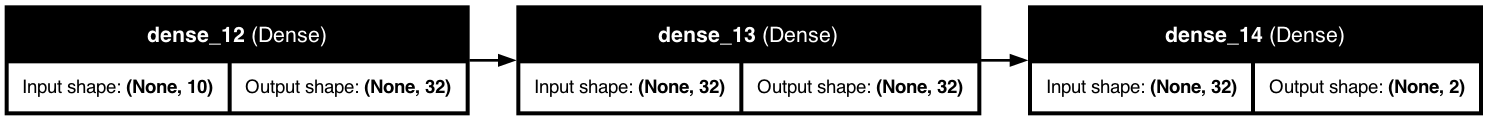

In [36]:
# =============================================================================
# BLOCK 2: MODEL ARCHITECTURE (The Neural Network)
# =============================================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the Model
model = Sequential([
    # 1. Explicit Input Layer (The "Door" for data)
    # Shape is (10,) because Window=5 * 2 (Real/Imag)
    Input(shape=(WINDOW_SIZE * 2,)), 
    
    # 2. Hidden Layer 1: 32 Neurons
    # Now it knows automatically what to expect from the Input layer
    Dense(32, activation='tanh'), 
    
    # 3. Hidden Layer 2: 32 Neurons
    Dense(32, activation='tanh'),
    
    # 4. Output Layer: 2 Neurons (Predicted I & Q)
    Dense(2, activation='linear') 
])

# Compile as before
model.compile(optimizer='adam', loss='mse')

model.summary()

from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file='my_equalizer_architecture.png', 
           show_shapes=True, 
           show_layer_names=True,
           rankdir='LR',
           dpi=96) # Standard resolution

### BLOCK 3: TRAINING & VISUALIZATION (CORRECTED)

Starting Training...
Running Inference...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


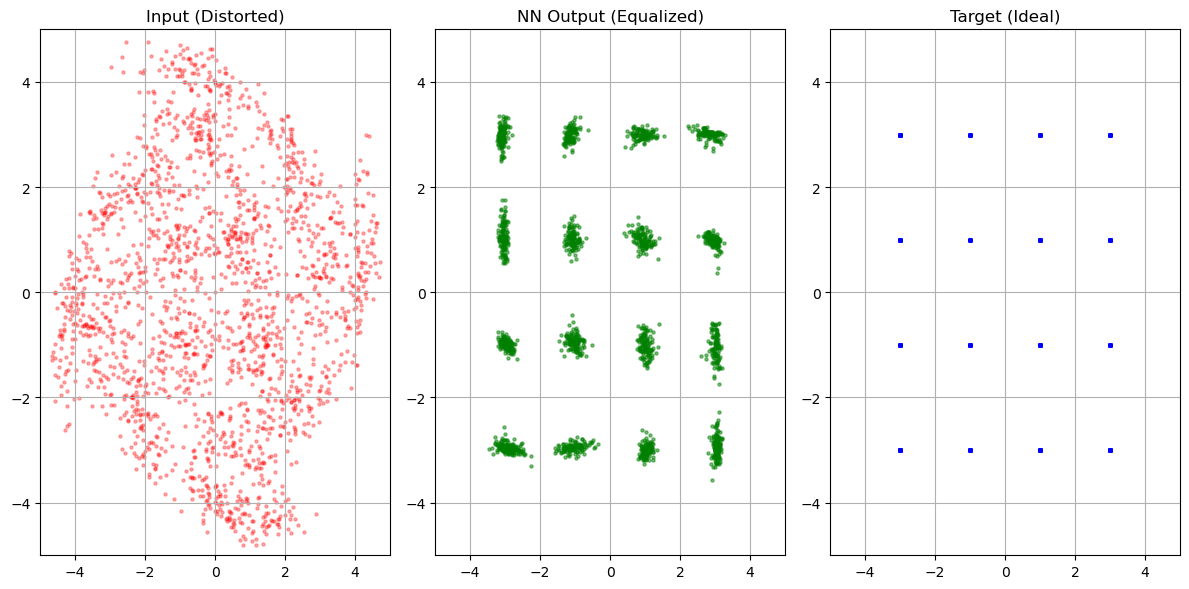

MSE Before Equalization: 20.0942
MSE After Equalization:  0.0520
Improvement Factor:      386.15x


In [ ]:
# =============================================================================
# BLOCK 3: TRAINING & VISUALIZATION (CORRECTED)
# =============================================================================
import matplotlib.pyplot as plt

# 1. Train
print("Starting Training...")
history = model.fit(X_train, y_train, 
                    epochs=500,           
                    batch_size=32,       
                    validation_split=0.1, 
                    verbose=0) # Sshh, less noise

# 2. Predict (Inference)
print("Running Inference...")
y_pred_scaled = model.predict(X_test)

# --- CRITICAL FIX: UN-SCALE THE OUTPUT ---
# We divided by 4 earlier. Now we multiply by 4 to get back to -3..+3 range.
SCALE_FACTOR = max_val
y_pred_real = y_pred_scaled * SCALE_FACTOR 

# Reconstruct Complex Numbers for Plotting
y_pred_complex = y_pred_real[:, 0] + 1j * y_pred_real[:, 1]
y_target_complex = y_test[:, 0] * SCALE_FACTOR + 1j * y_test[:, 1] * SCALE_FACTOR 
# Note: y_test was also scaled, so we un-scale it too for the plot comparison

# 3. VISUALIZATION
plt.figure(figsize=(12, 6))

# Plot 1: Input (What the NN saw)
# We take the center sample from X_test and un-scale it
center_real = X_test[:, 2] * SCALE_FACTOR
center_imag = X_test[:, 7] * SCALE_FACTOR
rx_center_complex = center_real + 1j * center_imag

plt.subplot(1, 3, 1)
plt.scatter(rx_center_complex.real, rx_center_complex.imag, c='red', s=5, alpha=0.3)
plt.title("Input (Distorted)")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot 2: NN Output (Equalized)
plt.subplot(1, 3, 2)
plt.scatter(y_pred_complex.real, y_pred_complex.imag, c='green', s=5, alpha=0.5)
plt.title("NN Output (Equalized)")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot 3: Target (Ideal)
plt.subplot(1, 3, 3)
plt.scatter(y_target_complex.real, y_target_complex.imag, c='blue', s=5, alpha=0.5)
plt.title("Target (Ideal)")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

plt.tight_layout()
plt.show()

# 4. MSE Calculation (On Real World Values)
input_mse = np.mean(np.abs(y_target_complex - rx_center_complex)**2)
output_mse = np.mean(np.abs(y_target_complex - y_pred_complex)**2)

print(f"MSE Before Equalization: {input_mse:.4f}")
print(f"MSE After Equalization:  {output_mse:.4f}")
print(f"Improvement Factor:      {input_mse/output_mse:.2f}x")

### BLOCK 5: THE ULTIMATE BENCHMARK (Linear MMSE & Baseline vs. NN)

Computing Linear MMSE (Wiener Filter)...
Computing Baseline Slicer (Raw Channel)...

FINAL PROJECT RESULTS (Symbol Error Rate)
1. Baseline (Raw Input):   0.93950 (94.0%)
2. Linear MMSE (DSP):      0.13100 (13.1%)
3. Neural Network (You):   0.00000 (0.0%)


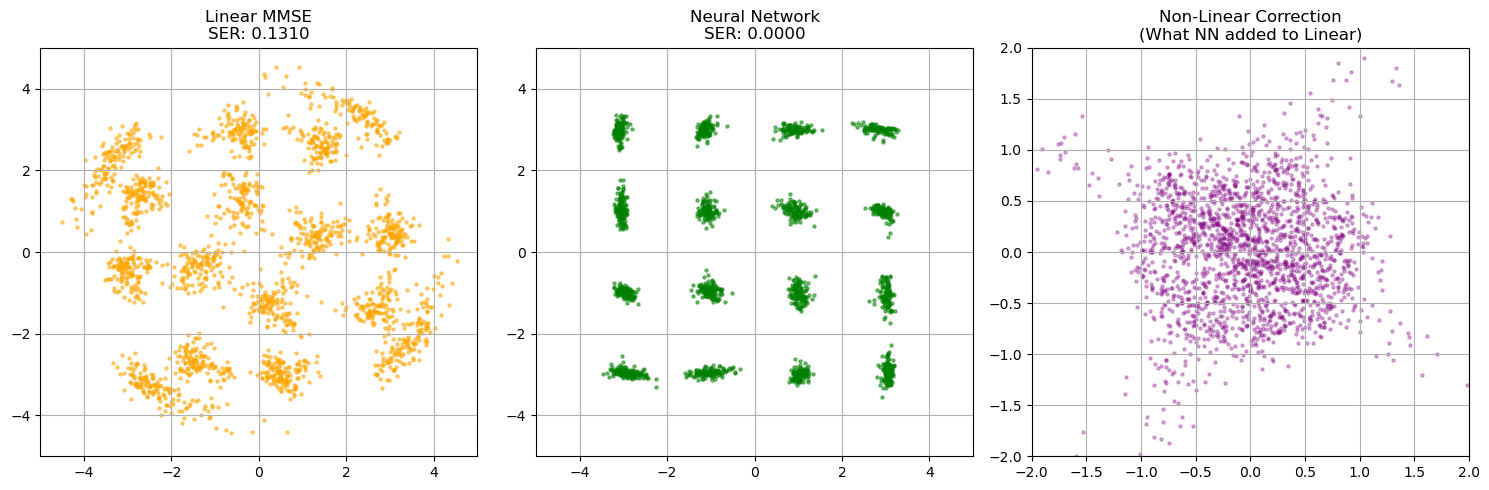

In [30]:
# =============================================================================
# BLOCK 5: THE ULTIMATE BENCHMARK (Linear MMSE & Baseline vs. NN)
# =============================================================================
from sklearn.linear_model import LinearRegression
import numpy as np

# --- Helper: Symbol De-mapper (Convert Complex -> Integer ID 0..15) ---
# We need this to count "Bit Errors" (or Symbol Errors) accurately
def get_symbol_id(complex_data):
    # Hard-coded thresholds for 16-QAM [-3, -1, 1, 3]
    # We slice at [-2, 0, 2]
    thresholds = np.array([-2, 0, 2])
    
    # Real part ID (0, 1, 2, 3)
    re_id = np.digitize(complex_data.real, thresholds)
    # Imag part ID (0, 1, 2, 3)
    im_id = np.digitize(complex_data.imag, thresholds)
    
    return re_id * 4 + im_id

# --- 1. Linear MMSE (The Theoretical Linear Limit) ---
print("Computing Linear MMSE (Wiener Filter)...")
# Scikit-Learn's LinearRegression mathematically solves the Wiener equation:
# W_opt = (R_xx)^-1 * R_xy
# This gives the BEST possible result obtainable by ANY linear filter.
linear_mmse = LinearRegression()
linear_mmse.fit(X_train, y_train)

# Predict using Linear MMSE
y_pred_lmmse_scaled = linear_mmse.predict(X_test)
y_pred_lmmse = y_pred_lmmse_scaled * SCALE_FACTOR
y_pred_lmmse_complex = y_pred_lmmse[:,0] + 1j * y_pred_lmmse[:,1]

# --- 2. Baseline MLD (The "Slicer" / No-Equalizer) ---
print("Computing Baseline Slicer (Raw Channel)...")
# Just take the center received sample and map it to nearest grid point
# X_test has 10 columns. Index 4 is Real(t), Index 9 is Imag(t)
rx_center_real = X_test[:, 4] * SCALE_FACTOR
rx_center_imag = X_test[:, 9] * SCALE_FACTOR
y_pred_slicer_complex = rx_center_real + 1j * rx_center_imag

# --- 3. Calculate Error Rates (SER) ---
# Ground Truth
y_test_real = y_test[:, 0] * SCALE_FACTOR
y_test_imag = y_test[:, 1] * SCALE_FACTOR
y_true_complex = y_test_real + 1j * y_test_imag
true_ids = get_symbol_id(y_true_complex)

# A. Baseline SER
pred_ids_slicer = get_symbol_id(y_pred_slicer_complex)
ser_slicer = np.mean(true_ids != pred_ids_slicer)

# B. Linear MMSE SER
pred_ids_lmmse = get_symbol_id(y_pred_lmmse_complex)
ser_lmmse = np.mean(true_ids != pred_ids_lmmse)

# C. Neural Network SER (From your previous Block 3 prediction)
# (Assuming y_pred_complex exists from previous block)
pred_ids_nn = get_symbol_id(y_pred_complex)
ser_nn = np.mean(true_ids != pred_ids_nn)

# --- 4. PRINT THE FINAL SCORECARD ---
print(f"\n{'='*45}")
print(f"FINAL PROJECT RESULTS (Symbol Error Rate)")
print(f"{'='*45}")
print(f"1. Baseline (Raw Input):   {ser_slicer:.5f} ({(ser_slicer*100):.1f}%)")
print(f"2. Linear MMSE (DSP):      {ser_lmmse:.5f} ({(ser_lmmse*100):.1f}%)")
print(f"3. Neural Network (You):   {ser_nn:.5f} ({(ser_nn*100):.1f}%)")
print(f"{'='*45}")

# --- 5. Visual Comparison Plot ---
plt.figure(figsize=(15, 5))

# Plot 1: Linear MMSE (The Competitor)
plt.subplot(1, 3, 1)
plt.scatter(y_pred_lmmse_complex.real, y_pred_lmmse_complex.imag, c='orange', s=5, alpha=0.5)
plt.title(f"Linear MMSE\nSER: {ser_lmmse:.4f}")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot 2: Neural Network (The Winner)
plt.subplot(1, 3, 2)
plt.scatter(y_pred_complex.real, y_pred_complex.imag, c='green', s=5, alpha=0.5)
plt.title(f"Neural Network\nSER: {ser_nn:.4f}")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot 3: Difference (Residuals)
# What did the NN fix that Linear missed?
residuals = y_pred_complex - y_pred_lmmse_complex
plt.subplot(1, 3, 3)
plt.scatter(residuals.real, residuals.imag, c='purple', s=5, alpha=0.3)
plt.title("Non-Linear Correction\n(What NN added to Linear)")
plt.grid(True); plt.xlim(-2, 2); plt.ylim(-2, 2)

plt.tight_layout()
plt.show()

### BLOCK 6: HARDWARE EXPORT (Extract Weights for Verilog)

In [34]:
# =============================================================================
# BLOCK 6: HARDWARE EXPORT (Extract Weights for Verilog)
# =============================================================================
import numpy as np

# 1. Get the weights from the trained model
# Layer 1 (Hidden)
W1, b1 = model.layers[0].get_weights()
# Layer 2 (Hidden)
W2, b2 = model.layers[1].get_weights()
# Layer 3 (Output)
W3, b3 = model.layers[2].get_weights()

print(f"--- HARDWARE SPECS ---")
print(f"Input Features: {W1.shape[0]} (Real/Imag parts of 5 symbols)")
print(f"Hidden Neurons: {W1.shape[1]}")
print(f"Output Neurons: {W3.shape[1]} (Real/Imag of 1 symbol)")

# 2. Peek at the values (to help us choose Fixed-Point precision)
# We need to know the MAX and MIN values to decide how many bits to use.
all_weights = np.concatenate([W1.flatten(), b1.flatten(), W2.flatten(), b2.flatten(), W3.flatten(), b3.flatten()])
print(f"\n--- QUANTIZATION GUIDE ---")
print(f"Max Weight Value: {np.max(all_weights):.4f}")
print(f"Min Weight Value: {np.min(all_weights):.4f}")
print(f"suggested: If range is roughly -2.0 to +2.0, we might need 2 integer bits + 6 fractional bits.")

# 3. Export to Text (Optional - save for later)
# np.savetxt("weights_layer1.txt", W1.flatten())
# np.savetxt("bias_layer1.txt", b1.flatten())
np.savetxt("weights.txt",all_weights)

--- HARDWARE SPECS ---
Input Features: 10 (Real/Imag parts of 5 symbols)
Hidden Neurons: 32
Output Neurons: 2 (Real/Imag of 1 symbol)

--- QUANTIZATION GUIDE ---
Max Weight Value: 1.9282
Min Weight Value: -3.7592
suggested: If range is roughly -2.0 to +2.0, we might need 2 integer bits + 6 fractional bits.
